# Chapter 4. Reinforcement Learning: Exercise
**Exercise Author:** Bach Nguyen

### Imports and Environment Setups

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

class Environment:
    """Class for a reinforcement learning environment"""
    
    def __init__(self, nstate=3, naction=2):
        """Create a new environment"""
        self.Ns = nstate   # number of states
        self.Na = naction  # number of actions
        
    def reset(self):
        """start an episode"""
        # randomly pick a state
        self.state = np.random.randint(self.Ns)
        return self.state
    
    def step(self, action):
        """step by an action"""
        # random reward
        self.reward = np.random.random()  # between 0 and 1
        # random next state
        self.state = np.random.randint(self.Ns)
        return self.state, self.reward
    
class Agent:
    """Class for a reinforcement learning agent"""
    
    def __init__(self, nstate, naction):
        """Create a new agent"""
        self.Ns = nstate   # number of states
        self.Na = naction  # number of actions
            
    def step(self, state, reward=None):
        """learn by reward and take an action"""
        # do nothing for reward
        # randomly pick an action
        self.action = np.random.randint(self.Na)
        return self.action
    
class RL:
    """Reinforcement learning by interacton of Environment and Agent"""

    def __init__(self, environment, agent, nstate, naction):
        """Create the environment and the agent"""
        self.env = environment(nstate, naction)
        self.agent = agent(nstate, naction)
    
    def episode(self, tmax=50):
        """One episode"""
        # First contact
        state = self.env.reset()
        action = self.agent.step(state)
        # Table of t, r, s, a
        Trsa = np.zeros((tmax+1, 4))
        Trsa[0] = [0, 0, state, action]
        # Repeat interactoin
        for t in range(1, tmax+1):
            state, reward = self.env.step(action)
            action = self.agent.step(state, reward)
            Trsa[t,:] = [t, reward, state, action]
        return(Trsa)
    
    def run(self, nrun=10, tmax=50):
        """Multiple runs of episodes"""
        Return = np.zeros(nrun)
        for n in range(nrun):
            r = self.episode(tmax)[:,1]  # reward sequence
            Return[n] = sum(r)
        return(Return)

In [3]:
class PainGain(Environment):
    """Pain-Gain environment """
    
    def __init__(self, nstate=4, naction=2, gain=6):
        super().__init__(nstate, naction)
        # setup the reward function as an array
        self.R = np.ones((self.Ns, self.Na)) # small gains
        self.R[:,1] = -1   # small pains for 2nd action (a=1)
        self.R[0,0] = -gain  # large pain
        self.R[-1,1] = gain  # large gain
    
    def step(self, action):
        """step by an action"""
        # reward by the reward matrix
        self.reward = self.R[self.state, action]
        # move left or right and circle
        self.state = (self.state + 2*action-1)%self.Ns  
        return self.state, self.reward

### **1.** Implement SARSA

#### **1.1** QL (from textbook) and SARSA Agents

In [4]:
class QL(Agent):
    """Class for a Q-learning agent"""

    def __init__(self, nstate, naction):
        super().__init__(nstate, naction)
        # allocate Q table
        self.Q = np.zeros((nstate, naction))
        # default parameters
        self.alpha = 0.1  # learning rate
        self.beta = 1.0   # inverse temperature
        self.gamma = 0.9  # discount factor
    
    def boltzmann(self, q):
        """Boltzmann selection"""
        pr = np.exp( self.beta*q)   # unnormalized probability
        pr = pr/sum(pr)    # probability
        return np.random.choice(len(pr), p=pr)
    
    def step(self, state, reward=None):
        """learn by reward and take an action"""
        if reward != None:
            # TD error: self.state/action retains the previous ones
            delta = reward + self.gamma*max(self.Q[state,:]) - self.Q[self.state,self.action]
            # Update the value for previous state and action
            self.Q[self.state,self.action] += self.alpha*delta
        # Boltzmann action selection
        self.action = self.boltzmann( self.Q[state,:])
        # remember the state
        self.state = state
        return self.action

class SARSA(Agent):
    """Class for a SARSA agent"""

    def __init__(self, nstate, naction):
        super().__init__(nstate, naction)
        # allocate Q table
        self.Q = np.zeros((nstate, naction))
        # default parameters
        self.alpha = 0.1  # learning rate
        self.beta = 1.0   # inverse temperature
        self.gamma = 0.9  # discount factor
        # initialize next action
        self.next_action = None
    
    def boltzmann(self, q):
        """Boltzmann selection"""
        pr = np.exp( self.beta*q)   # unnormalized probability
        pr = pr/sum(pr)    # probability
        return np.random.choice(len(pr), p=pr)
    
    def step(self, state, reward=None):
        """learn by reward and take an action"""
        if reward != None and hasattr(self, 'state'):
            # SARSA update: use the actual next action (on-policy)
            delta = reward + self.gamma*self.Q[state, self.next_action] - self.Q[self.state, self.action]
            # Update the value for previous state and action
            self.Q[self.state, self.action] += self.alpha*delta
            # Use the pre-selected next action
            self.action = self.next_action
        else:
            # First step or no reward: select action normally
            self.action = self.boltzmann(self.Q[state,:])
        
        # Pre-select the next action for the next step (needed for SARSA update)
        self.next_action = self.boltzmann(self.Q[state,:])
        # remember the state
        self.state = state
        return self.action

#### **1.2** Test SARSA

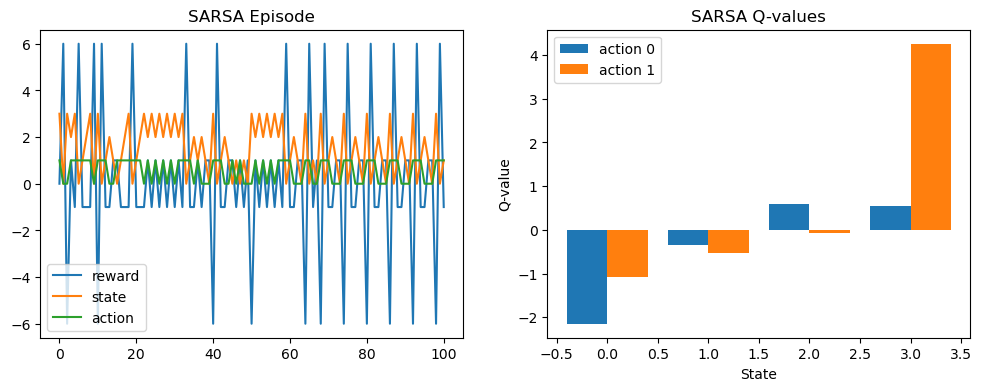

In [5]:
# Test SARSA with Pain-Gain environment
pgs = RL(PainGain, SARSA, 4, 2)
# customize parameters
pgs.agent.beta = 2

# run an episode
trsa_sarsa = pgs.episode(100)
plt.figure(figsize=(12, 4))

# Plot SARSA results
plt.subplot(1, 2, 1)
plt.plot(trsa_sarsa[:,1:])
plt.legend(("reward", "state", "action"))
plt.title("SARSA Episode")

# Visualize Q function for SARSA
plt.subplot(1, 2, 2)
plt.bar(np.arange(4)-0.2, pgs.agent.Q[:,0], 0.4, label='action 0')  # action0
plt.bar(np.arange(4)+0.2, pgs.agent.Q[:,1], 0.4, label='action 1')  # action1
plt.title("SARSA Q-values")
plt.xlabel("State")
plt.ylabel("Q-value")
plt.legend()
plt.show()

#### **1.3** Compare Q-learning and SARSA

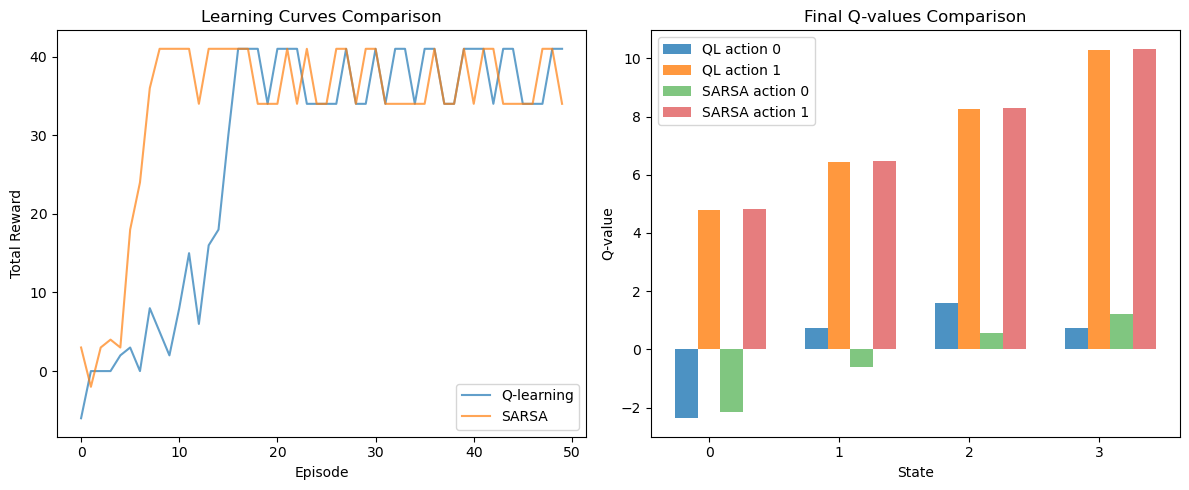

Q-learning average return: 27.92 ± 15.65
SARSA average return: 33.28 ± 11.35


In [6]:
# Compare Q-learning and SARSA learning curves
plt.figure(figsize=(12, 5))

# Q-learning
pgq = RL(PainGain, QL, 4, 2)
pgq.agent.beta = 2
R_ql = pgq.run(50, 50)

# SARSA
pgs = RL(PainGain, SARSA, 4, 2)
pgs.agent.beta = 2
R_sarsa = pgs.run(50, 50)

# Plot comparison
plt.subplot(1, 2, 1)
plt.plot(R_ql, label='Q-learning', alpha=0.7)
plt.plot(R_sarsa, label='SARSA', alpha=0.7)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Learning Curves Comparison')
plt.legend()

# Plot final Q-values comparison
plt.subplot(1, 2, 2)
width = 0.35
x = np.arange(4)
plt.bar(x - width/2, pgq.agent.Q[:,0], width/2, label='QL action 0', alpha=0.8)
plt.bar(x - width/2 + width/2, pgq.agent.Q[:,1], width/2, label='QL action 1', alpha=0.8)
plt.bar(x + width/2, pgs.agent.Q[:,0], width/2, label='SARSA action 0', alpha=0.6)
plt.bar(x + width/2 + width/2, pgs.agent.Q[:,1], width/2, label='SARSA action 1', alpha=0.6)
plt.xlabel('State')
plt.ylabel('Q-value')
plt.title('Final Q-values Comparison')
plt.legend()
plt.xticks(x)
plt.tight_layout()
plt.show()

print(f"Q-learning average return: {np.mean(R_ql):.2f} ± {np.std(R_ql):.2f}")
print(f"SARSA average return: {np.mean(R_sarsa):.2f} ± {np.std(R_sarsa):.2f}")

### **2.** Implement Actor-Critic

#### **2.1** Actor-Critic Agent

In [7]:
class ActorCritic(Agent):
    """Class for an Actor-Critic agent"""

    def __init__(self, nstate, naction):
        super().__init__(nstate, naction)
        # Actor: policy parameters (preference for each action in each state)
        self.theta = np.zeros((nstate, naction))
        # Critic: state value function
        self.V = np.zeros(nstate)
        # default parameters
        self.alpha_theta = 0.1  # learning rate for actor (policy)
        self.alpha_v = 0.1      # learning rate for critic (value function)
        self.beta = 1.0         # inverse temperature for policy
        self.gamma = 0.9        # discount factor
    
    def policy(self, state):
        """Softmax policy based on preferences"""
        # Apply softmax to get action probabilities
        exp_theta = np.exp(self.beta * self.theta[state, :])
        probs = exp_theta / np.sum(exp_theta)
        return probs
    
    def select_action(self, state):
        """Select action according to policy"""
        probs = self.policy(state)
        return np.random.choice(self.Na, p=probs)
    
    def step(self, state, reward=None):
        """learn by reward and take an action"""
        if reward is not None and hasattr(self, 'state'):
            # Critic update: TD error for state value
            td_error = reward + self.gamma * self.V[state] - self.V[self.state]
            
            # Update critic (state value)
            self.V[self.state] += self.alpha_v * td_error
            
            # Actor update: policy gradient
            # Get current policy probabilities for previous state
            probs = self.policy(self.state)
            
            # Update policy parameters using policy gradient
            for a in range(self.Na):
                if a == self.action:
                    # For the selected action: gradient is (1 - π(a|s))
                    grad = 1 - probs[a]
                else:
                    # For non-selected actions: gradient is (-π(a|s))
                    grad = -probs[a]
                
                self.theta[self.state, a] += self.alpha_theta * td_error * grad
        
        # Select action for current state
        self.action = self.select_action(state)
        # Remember the state
        self.state = state
        return self.action

#### **2.2** Test Actor-Critic

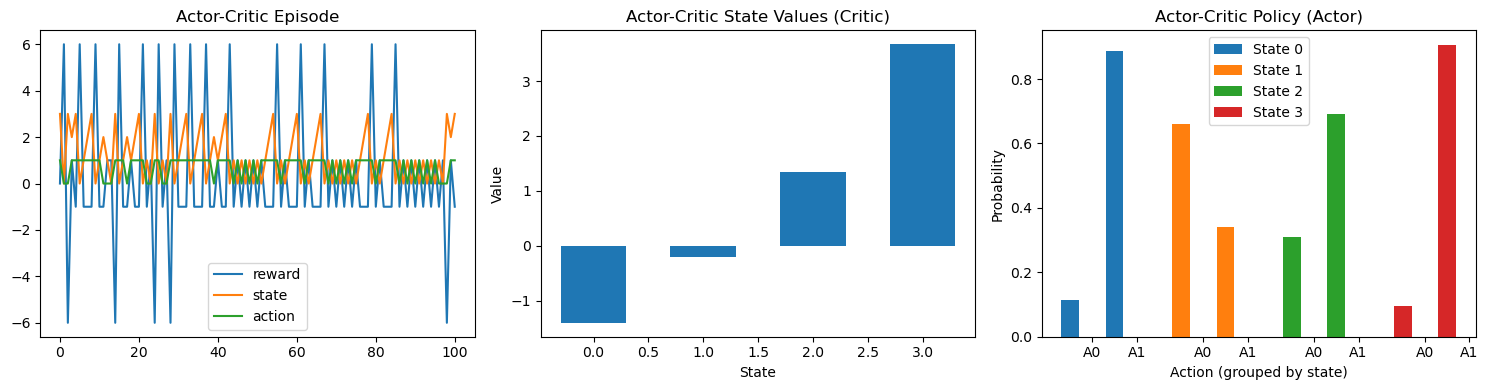

In [8]:
# Test Actor-Critic with Pain-Gain environment
pgac = RL(PainGain, ActorCritic, 4, 2)
# customize parameters
pgac.agent.beta = 2
pgac.agent.alpha_theta = 0.05  # smaller learning rate for policy
pgac.agent.alpha_v = 0.1       # learning rate for value function

# run an episode
trsa_ac = pgac.episode(100)
plt.figure(figsize=(15, 4))

# Plot Actor-Critic results
plt.subplot(1, 3, 1)
plt.plot(trsa_ac[:,1:])
plt.legend(("reward", "state", "action"))
plt.title("Actor-Critic Episode")

# Visualize Value function (Critic)
plt.subplot(1, 3, 2)
plt.bar(np.arange(4), pgac.agent.V, 0.6)
plt.title("Actor-Critic State Values (Critic)")
plt.xlabel("State")
plt.ylabel("Value")

# Visualize Policy (Actor) - action probabilities
plt.subplot(1, 3, 3)
for s in range(4):
    probs = pgac.agent.policy(s)
    plt.bar(np.arange(2) + s*2.5, probs, 0.4, label=f'State {s}')
plt.title("Actor-Critic Policy (Actor)")
plt.xlabel("Action (grouped by state)")
plt.ylabel("Probability")
plt.legend()
plt.xticks([0.5, 1.5, 3, 4, 5.5, 6.5, 8, 9], 
           ['A0', 'A1', 'A0', 'A1', 'A0', 'A1', 'A0', 'A1'])
plt.tight_layout()
plt.show()

#### **2.3** Compare Actor-Critic and SARSA

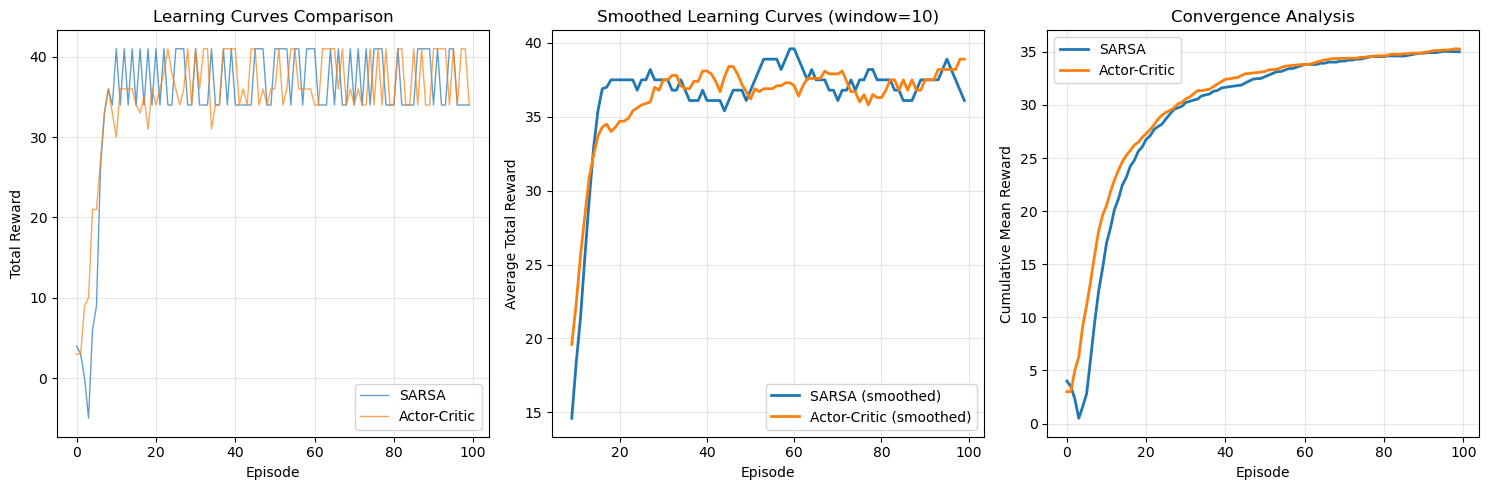

PERFORMANCE COMPARISON: SARSA vs Actor-Critic
SARSA:
  Average return: 35.00 ± 8.93
  Min/Max: -5.00 / 41.00
  Final 10 episodes mean: 36.10

Actor-Critic:
  Average return: 35.27 ± 7.16
  Min/Max: 3.00 / 41.00
  Final 10 episodes mean: 38.90

Difference in average performance: 0.27


In [9]:
# Compare SARSA and Actor-Critic learning curves
plt.figure(figsize=(15, 5))

# SARSA
pgs = RL(PainGain, SARSA, 4, 2)
pgs.agent.beta = 2
R_sarsa = pgs.run(100, 50)

# Actor-Critic
pgac = RL(PainGain, ActorCritic, 4, 2)
pgac.agent.beta = 2
pgac.agent.alpha_theta = 0.05
pgac.agent.alpha_v = 0.1
R_ac = pgac.run(100, 50)

# Plot learning curves comparison
plt.subplot(1, 3, 1)
plt.plot(R_sarsa, label='SARSA', alpha=0.7, linewidth=1)
plt.plot(R_ac, label='Actor-Critic', alpha=0.7, linewidth=1)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Learning Curves Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot moving averages for clearer trends
window = 10
plt.subplot(1, 3, 2)
sarsa_smooth = np.convolve(R_sarsa, np.ones(window)/window, mode='valid')
ac_smooth = np.convolve(R_ac, np.ones(window)/window, mode='valid')
plt.plot(range(window-1, len(R_sarsa)), sarsa_smooth, label='SARSA (smoothed)', linewidth=2)
plt.plot(range(window-1, len(R_ac)), ac_smooth, label='Actor-Critic (smoothed)', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Average Total Reward')
plt.title(f'Smoothed Learning Curves (window={window})')
plt.legend()
plt.grid(True, alpha=0.3)

# Convergence analysis
plt.subplot(1, 3, 3)
# Calculate cumulative mean to show convergence
cum_mean_sarsa = np.cumsum(R_sarsa) / np.arange(1, len(R_sarsa) + 1)
cum_mean_ac = np.cumsum(R_ac) / np.arange(1, len(R_ac) + 1)
plt.plot(cum_mean_sarsa, label='SARSA', linewidth=2)
plt.plot(cum_mean_ac, label='Actor-Critic', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Cumulative Mean Reward')
plt.title('Convergence Analysis')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed comparison
print("=" * 60)
print("PERFORMANCE COMPARISON: SARSA vs Actor-Critic")
print("=" * 60)
print(f"SARSA:")
print(f"  Average return: {np.mean(R_sarsa):.2f} ± {np.std(R_sarsa):.2f}")
print(f"  Min/Max: {np.min(R_sarsa):.2f} / {np.max(R_sarsa):.2f}")
print(f"  Final 10 episodes mean: {np.mean(R_sarsa[-10:]):.2f}")
print(f"\nActor-Critic:")
print(f"  Average return: {np.mean(R_ac):.2f} ± {np.std(R_ac):.2f}")
print(f"  Min/Max: {np.min(R_ac):.2f} / {np.max(R_ac):.2f}")
print(f"  Final 10 episodes mean: {np.mean(R_ac[-10:]):.2f}")
print(f"\nDifference in average performance: {np.mean(R_ac) - np.mean(R_sarsa):.2f}")
print("=" * 60)


### **3.** Implement an environment of your interested and test RL algorithms.

#### **3.1** New Environment: Chain World

In [10]:
class ChainWorld(Environment):
    """Chain World Environment - A bit more complex than PainGain
    
    Features:
    - Linear chain of states (0, 1, 2, ..., n-1)
    - 3 actions: Left, Stay, Right
    - Stochastic transitions (actions may fail)
    - Rewards at terminal states
    - Episode ends when reaching terminal states
    """
    
    def __init__(self, nstate=8, naction=3, noise=0.2, goal_reward=10, trap_penalty=-5):
        super().__init__(nstate, naction)
        self.noise = noise  # Probability of action failure
        self.goal_reward = goal_reward
        self.trap_penalty = trap_penalty
        
        # Terminal states: leftmost is trap, rightmost is goal
        self.trap_state = 0
        self.goal_state = nstate - 1
        self.start_state = nstate // 2  # Start in middle
        
        # Action meanings: 0=Left, 1=Stay, 2=Right
        self.action_names = ['Left', 'Stay', 'Right']
        
    def reset(self):
        """Reset to starting state"""
        self.state = self.start_state
        self.done = False
        return self.state
    
    def step(self, action):
        """Take action in the environment"""
        if self.done:
            return self.state, 0
        
        # Add stochasticity: with probability 'noise', action becomes random
        if np.random.random() < self.noise:
            action = np.random.randint(self.Na)
        
        # Execute action
        if action == 0:  # Left
            new_state = max(0, self.state - 1)
        elif action == 1:  # Stay
            new_state = self.state
        else:  # Right (action == 2)
            new_state = min(self.Ns - 1, self.state + 1)
        
        # Calculate reward
        if new_state == self.goal_state:
            reward = self.goal_reward
            self.done = True
        elif new_state == self.trap_state:
            reward = self.trap_penalty
            self.done = True
        else:
            reward = -0.1  # Small step penalty to encourage reaching goal quickly
        
        self.state = new_state
        return self.state, reward
    
    def render(self):
        """Visualize the chain world"""
        print("\nChain World:")
        visual = []
        for i in range(self.Ns):
            if i == self.state:
                if i == self.trap_state:
                    visual.append('[T]')  # Agent at trap
                elif i == self.goal_state:
                    visual.append('[G]')  # Agent at goal
                else:
                    visual.append('[A]')  # Agent
            elif i == self.trap_state:
                visual.append(' T ')  # Trap
            elif i == self.goal_state:
                visual.append(' G ')  # Goal
            else:
                visual.append(' . ')  # Empty
        
        print(''.join(visual))
        print('T=Trap, G=Goal, A=Agent, .=Empty')
        print(f"Current state: {self.state}, Done: {self.done}")

In [11]:
# Create and test Chain World environment
print("=" * 60)
print("CHAIN WORLD ENVIRONMENT")
print("=" * 60)

# Create environment
chain_env = ChainWorld(nstate=8, naction=3, noise=0.2)
print(f"States: {chain_env.Ns}, Actions: {chain_env.Na}")
print(f"Noise probability: {chain_env.noise}")
print(f"Start state: {chain_env.start_state}")
print(f"Trap state: {chain_env.trap_state} (reward: {chain_env.trap_penalty})")
print(f"Goal state: {chain_env.goal_state} (reward: {chain_env.goal_reward})")

# Show initial state
state = chain_env.reset()
chain_env.render()

# Manual test with random actions
print("\nTesting with random actions:")
for step in range(5):
    if chain_env.done:
        break
    action = np.random.randint(3)
    next_state, reward = chain_env.step(action)
    print(f"Step {step+1}: Action {action} ({chain_env.action_names[action]}) -> State {next_state}, Reward: {reward:.1f}")
    chain_env.render()
    
if chain_env.done:
    print(f"Episode ended! Final state: {chain_env.state}")
else:
    print("Episode continues...")

CHAIN WORLD ENVIRONMENT
States: 8, Actions: 3
Noise probability: 0.2
Start state: 4
Trap state: 0 (reward: -5)
Goal state: 7 (reward: 10)

Chain World:
 T  .  .  . [A] .  .  G 
T=Trap, G=Goal, A=Agent, .=Empty
Current state: 4, Done: False

Testing with random actions:
Step 1: Action 2 (Right) -> State 5, Reward: -0.1

Chain World:
 T  .  .  .  . [A] .  G 
T=Trap, G=Goal, A=Agent, .=Empty
Current state: 5, Done: False
Step 2: Action 0 (Left) -> State 4, Reward: -0.1

Chain World:
 T  .  .  . [A] .  .  G 
T=Trap, G=Goal, A=Agent, .=Empty
Current state: 4, Done: False
Step 3: Action 1 (Stay) -> State 4, Reward: -0.1

Chain World:
 T  .  .  . [A] .  .  G 
T=Trap, G=Goal, A=Agent, .=Empty
Current state: 4, Done: False
Step 4: Action 0 (Left) -> State 3, Reward: -0.1

Chain World:
 T  .  . [A] .  .  .  G 
T=Trap, G=Goal, A=Agent, .=Empty
Current state: 3, Done: False
Step 5: Action 2 (Right) -> State 4, Reward: -0.1

Chain World:
 T  .  .  . [A] .  .  G 
T=Trap, G=Goal, A=Agent, .=Empty
Cur

#### **3.2** Test QL, SARSA, and Actor-Critic in ChainWorld


ALGORITHM COMPARISON ON CHAIN WORLD
Training agents on Chain World...


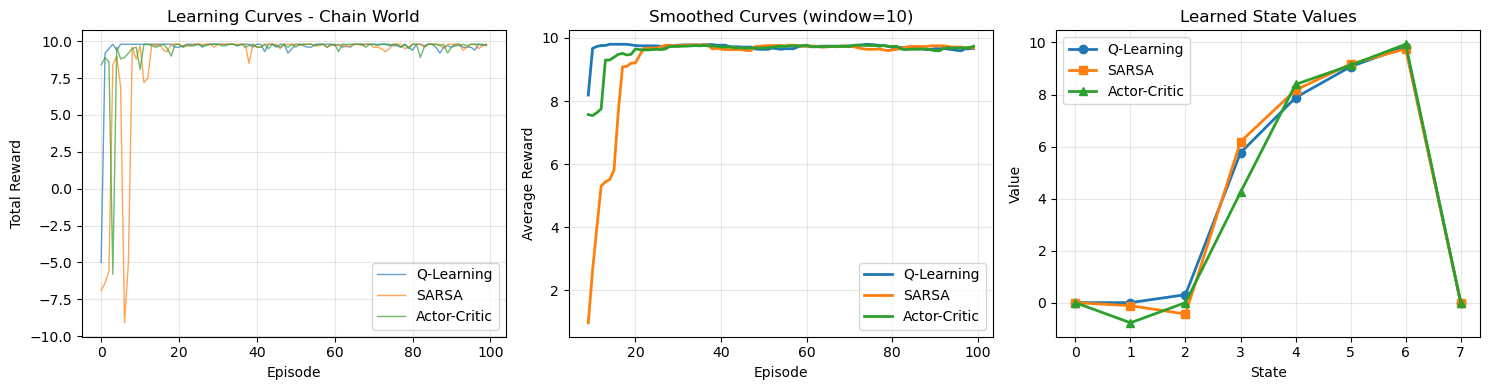


PERFORMANCE STATISTICS - CHAIN WORLD

Q-Learning:
  Mean reward: 9.57 ± 1.47
  Median reward: 9.80
  Min/Max reward: -5.00 / 9.80
  Success rate: 99.0%
  Final 10 episodes mean: 9.67
  First success at episode: 1

SARSA:
  Mean reward: 8.79 ± 3.58
  Median reward: 9.80
  Min/Max reward: -9.10 / 9.80
  Success rate: 95.0%
  Final 10 episodes mean: 9.70
  First success at episode: 3

Actor-Critic:
  Mean reward: 9.48 ± 1.57
  Median reward: 9.70
  Min/Max reward: -5.80 / 9.80
  Success rate: 99.0%
  Final 10 episodes mean: 9.74
  First success at episode: 0


In [12]:
# Test all three algorithms on Chain World
print("\n" + "="*80)
print("ALGORITHM COMPARISON ON CHAIN WORLD")
print("="*80)

plt.figure(figsize=(15, 4))

# Run multiple episodes for each algorithm
n_episodes = 100
episode_length = 50

print("Training agents on Chain World...")

# Q-Learning
chain_ql = RL(ChainWorld, QL, 8, 3)
chain_ql.agent.alpha = 0.2
chain_ql.agent.beta = 2.0
chain_ql.agent.gamma = 0.95
R_ql_chain = chain_ql.run(n_episodes, episode_length)

# SARSA
chain_sarsa = RL(ChainWorld, SARSA, 8, 3)
chain_sarsa.agent.alpha = 0.2
chain_sarsa.agent.beta = 2.0
chain_sarsa.agent.gamma = 0.95
R_sarsa_chain = chain_sarsa.run(n_episodes, episode_length)

# Actor-Critic
chain_ac = RL(ChainWorld, ActorCritic, 8, 3)
chain_ac.agent.alpha_theta = 0.1
chain_ac.agent.alpha_v = 0.2
chain_ac.agent.beta = 2.0
chain_ac.agent.gamma = 0.95
R_ac_chain = chain_ac.run(n_episodes, episode_length)

# 1. Learning Curves
plt.subplot(1, 3, 1)
plt.plot(R_ql_chain, label='Q-Learning', alpha=0.7, linewidth=1)
plt.plot(R_sarsa_chain, label='SARSA', alpha=0.7, linewidth=1)
plt.plot(R_ac_chain, label='Actor-Critic', alpha=0.7, linewidth=1)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Learning Curves - Chain World')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Smoothed Learning Curves
window = 10
plt.subplot(1, 3, 2)
ql_smooth = np.convolve(R_ql_chain, np.ones(window)/window, mode='valid')
sarsa_smooth = np.convolve(R_sarsa_chain, np.ones(window)/window, mode='valid')
ac_smooth = np.convolve(R_ac_chain, np.ones(window)/window, mode='valid')
plt.plot(range(window-1, len(R_ql_chain)), ql_smooth, label='Q-Learning', linewidth=2)
plt.plot(range(window-1, len(R_sarsa_chain)), sarsa_smooth, label='SARSA', linewidth=2)
plt.plot(range(window-1, len(R_ac_chain)), ac_smooth, label='Actor-Critic', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title(f'Smoothed Curves (window={window})')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. State Values Comparison
plt.subplot(1, 3, 3)
max_q_ql = np.max(chain_ql.agent.Q, axis=1)
max_q_sarsa = np.max(chain_sarsa.agent.Q, axis=1)
ac_values = chain_ac.agent.V

plt.plot(max_q_ql, 'o-', label='Q-Learning', linewidth=2)
plt.plot(max_q_sarsa, 's-', label='SARSA', linewidth=2)
plt.plot(ac_values, '^-', label='Actor-Critic', linewidth=2)
plt.xlabel('State')
plt.ylabel('Value')
plt.title('Learned State Values')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(range(8))

plt.tight_layout()
plt.show()

# Print detailed statistics
print("\n" + "="*80)
print("PERFORMANCE STATISTICS - CHAIN WORLD")
print("="*80)

success_threshold = 5.0
for name, rewards in [('Q-Learning', R_ql_chain), ('SARSA', R_sarsa_chain), ('Actor-Critic', R_ac_chain)]:
    print(f"\n{name}:")
    print(f"  Mean reward: {np.mean(rewards):.2f} ± {np.std(rewards):.2f}")
    print(f"  Median reward: {np.median(rewards):.2f}")
    print(f"  Min/Max reward: {np.min(rewards):.2f} / {np.max(rewards):.2f}")
    print(f"  Success rate: {np.sum(rewards > success_threshold)/len(rewards)*100:.1f}%")
    print(f"  Final 10 episodes mean: {np.mean(rewards[-10:]):.2f}")
    if len(np.where(rewards > success_threshold)[0]) > 0:
        print(f"  First success at episode: {np.where(rewards > success_threshold)[0][0]}")
    else:
        print(f"  First success: Never")
